In [1]:
import utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from pathlib import Path

2023-09-11 16:00:17.529757: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Using TensorFlow backend


In [2]:
def index_mcmc_runs():
    """Make a list of combinations for which we want to run MCMC."""
    experiments = ['AMS02_H-PRL2021', 'PAMELA_H-ApJ2013', 'PAMELA_H-ApJL2018']
    dfs = []
    for experiment_name in experiments:
        filename = f'../data/2023/{experiment_name}_heliosphere.dat'
        df = utils.index_experiment_files(filename) 
        df['experiment_name'] = experiment_name
        df['filename_heliosphere'] = filename
        dfs.append(df)
    df = pd.concat(dfs, axis=0, ignore_index=0)
    return df

# Select experiment parameters
df = index_mcmc_runs()  # List of all ~200 experiments.

# Model specification
version = 'v6.0' # 'v1.0'
reduce_by = 1 # Reduce the number of MCMC samples by this factor. v2.0: 9, v1.0 and v3.0: 1

# Setup  output directory.
results_dir = f'../../results/{version}/'
figs_dir = f'{results_dir}figs/'
Path(figs_dir).mkdir(parents=True, exist_ok=True)

print(df.head())
print(df.shape)

            interval  alpha   cmf  vspoles  alpha_std  cmf_std  vspoles_std  \
0  20110520-20110610  51.49  4.85   632.52      10.69     1.87        22.41   
1  20110611-20110707  53.61  4.87   627.62       9.80     1.82        22.70   
2  20110708-20110803  55.39  4.92   622.22       9.63     1.83        22.70   
3  20110804-20110830  57.12  4.95   616.76       9.44     1.86        22.80   
4  20110831-20110926  58.72  5.05   611.21       9.59     1.92        23.02   

   beginning     ending polarity  experiment_name  \
0 2011-05-20 2011-05-20      neg  AMS02_H-PRL2021   
1 2011-06-11 2011-06-11      neg  AMS02_H-PRL2021   
2 2011-07-08 2011-07-08      neg  AMS02_H-PRL2021   
3 2011-08-04 2011-08-04      neg  AMS02_H-PRL2021   
4 2011-08-31 2011-08-31      neg  AMS02_H-PRL2021   

                           filename_heliosphere  
0  ../data/2023/AMS02_H-PRL2021_heliosphere.dat  
1  ../data/2023/AMS02_H-PRL2021_heliosphere.dat  
2  ../data/2023/AMS02_H-PRL2021_heliosphere.dat  
3  ../

Filename: ../../results/v5.0/samples_40_AMS02_H-PRL2021_20140429-20140525_neg.csv


Samples shape: (109806, 5). Small samples shape: (2197, 5)


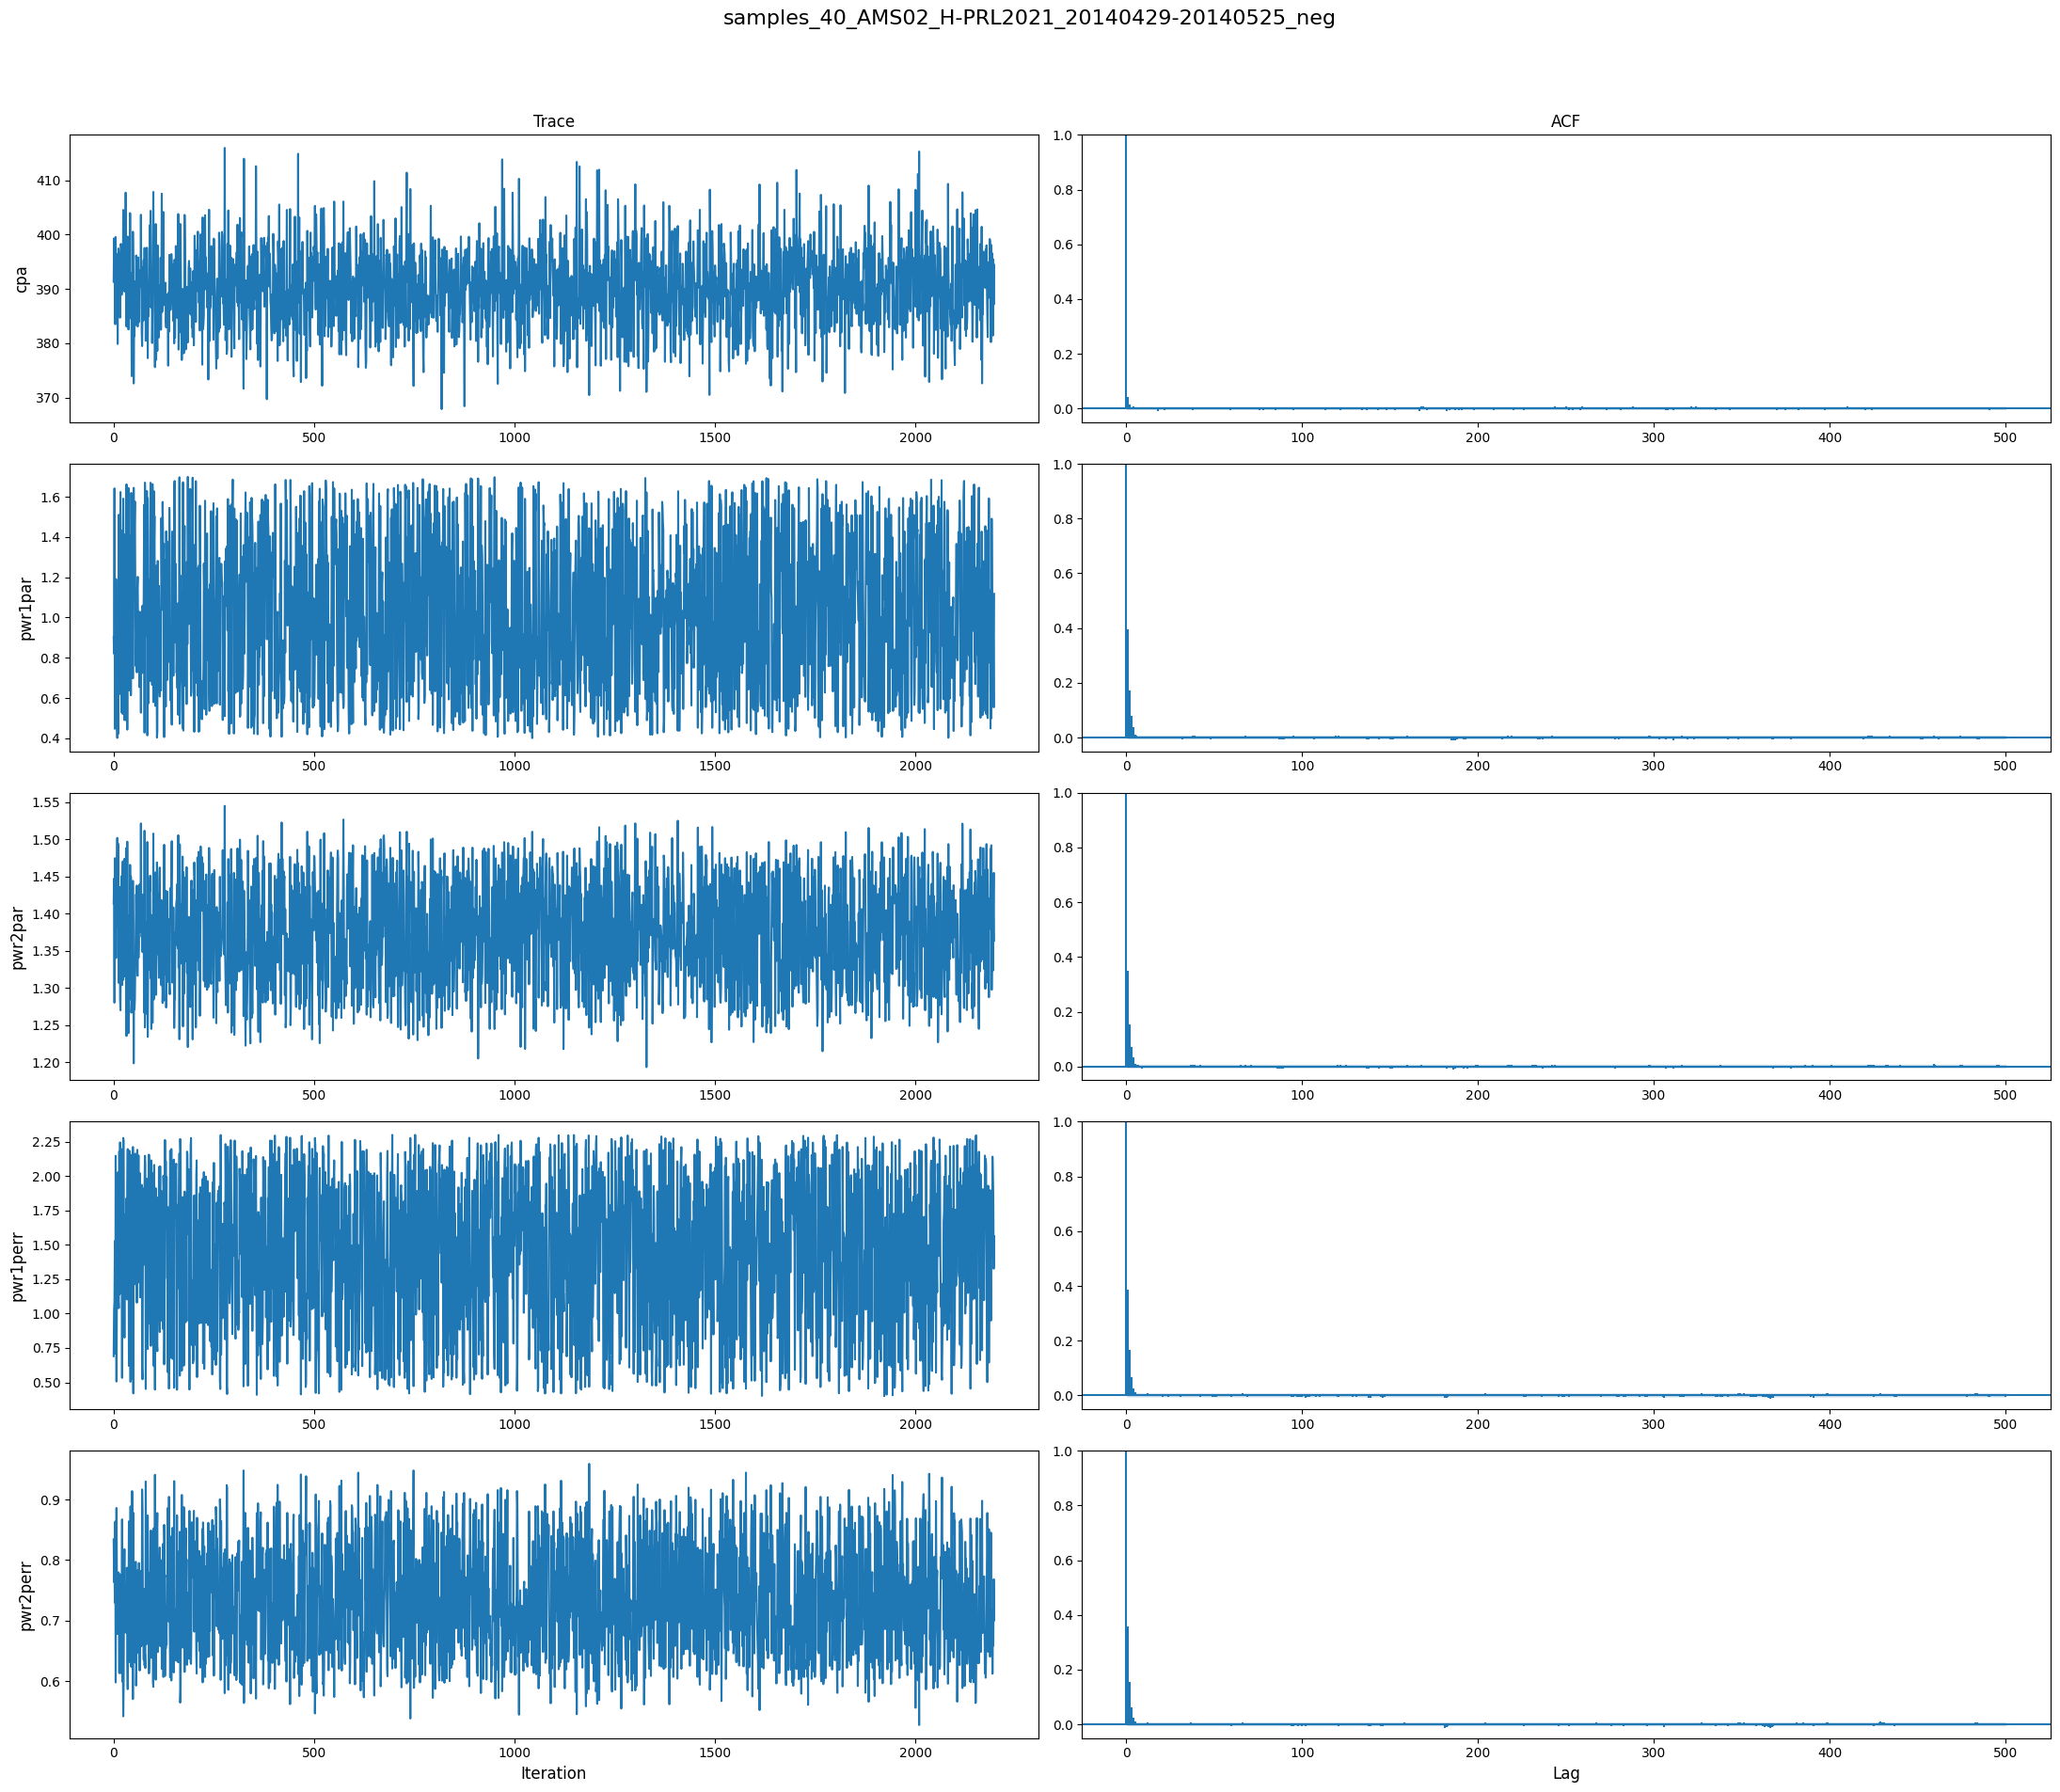

In [4]:
# Load samples, logprobs, and predictions to each respective index in the dataframe
for i in (0, len(df), 1):
    experiment_name = df["experiment_name"].iloc[i]
    interval = df.interval.iloc[i]
    polarity = df.polarity.iloc[i]

    filename = f'{results_dir}samples_{i}_{experiment_name}_{interval}_{polarity}.csv'
    print(f"Filename: {filename}")

    samples = np.loadtxt(filename, delimiter=',')
    # logprobs = np.loadtxt(f'{results_dir}logprobs_{i}_{experiment_name}_{interval}_{polarity}.csv', delimiter=',')
    # predictions = np.loadtxt(f'{results_dir}predictions_{i}_{experiment_name}_{interval}_{polarity}.csv', delimiter=',')
    
    # Examine only a few samples. Take 1 out of every 9 samples.
    samples = samples[::reduce_by, :]
    samples_small = samples[::50, :]
    print(f"Samples shape: {samples.shape}. Small samples shape: {samples_small.shape}")

    # Make a 5 by 2 plot of the trace and acf of the samples
    fig, axes = plt.subplots(5, 2, figsize=(22, 20))
    axes[0, 0].plot(samples_small[:, 0])
    axes[1, 0].plot(samples_small[:, 1])
    axes[2, 0].plot(samples_small[:, 2])
    axes[3, 0].plot(samples_small[:, 3])
    axes[4, 0].plot(samples_small[:, 4])

    lags = 500
    plot_acf(samples[:, 0], lags=lags, ax=axes[0, 1], title="", markersize=0)
    plot_acf(samples[:, 1], lags=lags, ax=axes[1, 1], title="", markersize=0)
    plot_acf(samples[:, 2], lags=lags, ax=axes[2, 1], title="", markersize=0)
    plot_acf(samples[:, 3], lags=lags, ax=axes[3, 1], title="", markersize=0)
    plot_acf(samples[:, 4], lags=lags, ax=axes[4, 1], title="", markersize=0)

    # Get min and maxc from acf plots
    min_y = -0.05
    max_y = 1.0

    axes[0, 1].set_ylim(min_y, max_y)
    axes[1, 1].set_ylim(min_y, max_y)
    axes[2, 1].set_ylim(min_y, max_y)
    axes[3, 1].set_ylim(min_y, max_y)
    axes[4, 1].set_ylim(min_y, max_y)

    # Make a title for each column and each row
    for ax, col in zip(axes[0], ['Trace', 'ACF']):
        ax.set_title(col)
    for ax, col in zip(axes[4], ['Iteration', 'Lag']):
        ax.set_xlabel(col, size='large')
    for ax, row in zip(axes[:,0], ['cpa', 'pwr1par', 'pwr2par', 'pwr1perr', 'pwr2perr']):
        ax.set_ylabel(row, size='large')

    # Set super title that is the filename
    fig.suptitle(f'samples_{i}_{experiment_name}_{interval}_{polarity}', fontsize=16)

    # Remove whitespace below title and between columns
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])   

    plt.savefig(f'{figs_dir}{i}_{experiment_name}_{interval}_{polarity}.png')
    plt.show()